___



<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Distribution Plots

Let's discuss some plots that allow us to visualize the distributionhttps://github.com/harrism/numba_examples.git of a data set. These plots are:

* distplot
* jointplot
* pairplot
* rugplot
* kdeplot

___
## Imports

In [1]:
import seaborn as sns
%matplotlib inline
sns.set()

## Data
Seaborn comes with built-in data sets!

In [2]:
tips = sns.load_dataset('tips')

In [3]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## distplot

The distplot shows the distribution of a univariate set of observations.

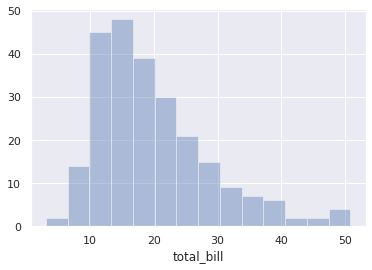

In [4]:
sns.distplot(tips['total_bill'], kde = False)
# Safe to ignore warnings

To remove the kde layer and just have the histogram use:

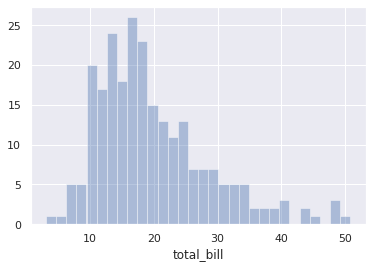

In [5]:
sns.distplot(tips['total_bill'],kde=False,bins=30)

## jointplot

jointplot() allows you to basically match up two distplots for bivariate data. With your choice of what **kind** parameter to compare with: 
* “scatter” 
* “reg” 
* “resid” 
* “kde” 
* “hex”

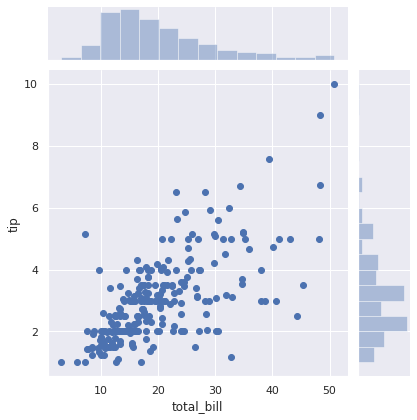

In [6]:
sns.jointplot(x='total_bill',y='tip',data=tips,kind='scatter')

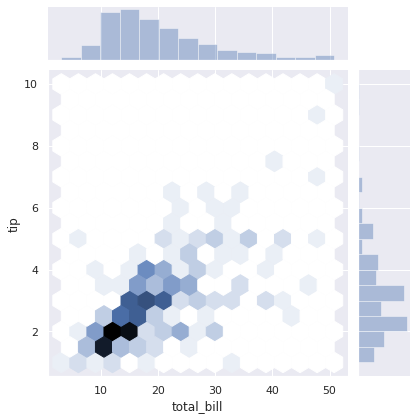

In [7]:
sns.jointplot(x='total_bill',y='tip',data=tips,kind='hex')

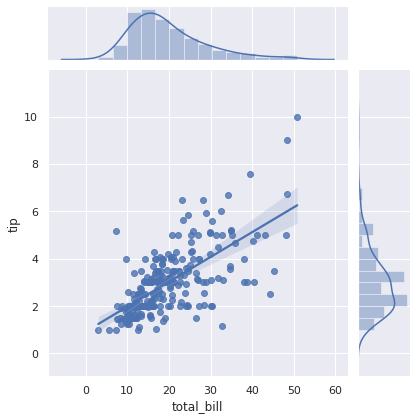

In [8]:
sns.jointplot(x='total_bill',y='tip',data=tips,kind='reg')

## pairplot

pairplot will plot pairwise relationships across an entire dataframe (for the numerical columns) and supports a color hue argument (for categorical columns). 

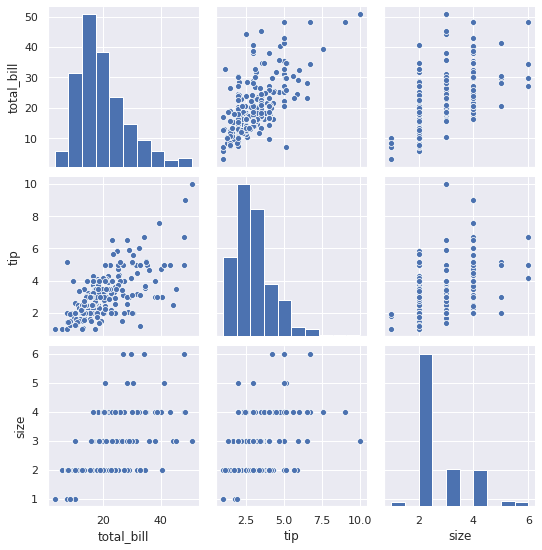

In [9]:
sns.pairplot(tips)

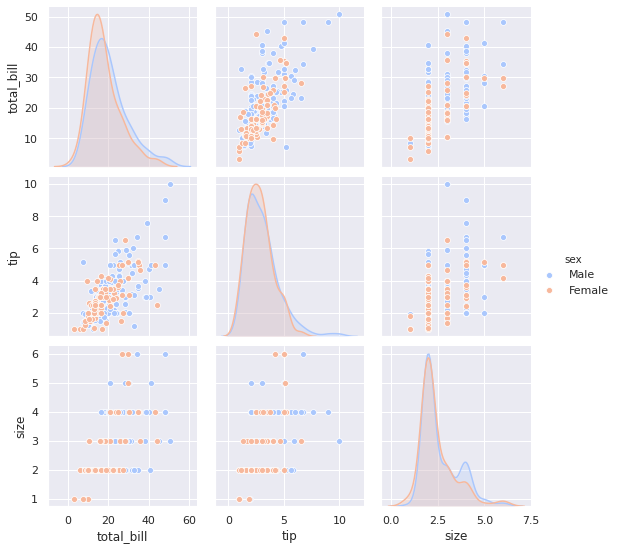

In [10]:
sns.pairplot(tips,hue='sex',palette='coolwarm')

## rugplot

rugplots are actually a very simple concept, they just draw a dash mark for every point on a univariate distribution. They are the building block of a KDE plot:

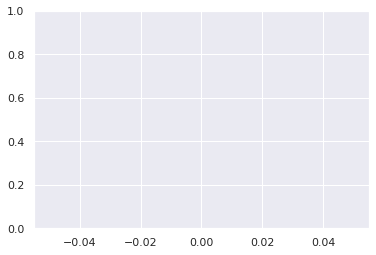

In [11]:
sns.rugplot(tips['total_bill'],)

## kdeplot

kdeplots are [Kernel Density Estimation plots](http://en.wikipedia.org/wiki/Kernel_density_estimation#Practical_estimation_of_the_bandwidth). These KDE plots replace every single observation with a Gaussian (Normal) distribution centered around that value. For example:

(0.0, 1.0)

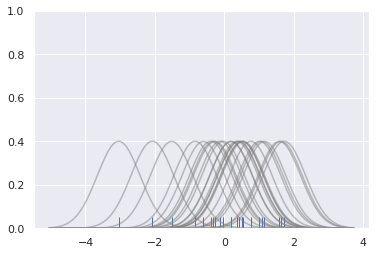

In [12]:
# Don't worry about understanding this code!
# It's just for the diagram below
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Create dataset
dataset = np.random.randn(25)

# Create another rugplot
sns.rugplot(dataset);

# Set up the x-axis for the plot
x_min = dataset.min() - 2
x_max = dataset.max() + 2

# 100 equally spaced points from x_min to x_max
x_axis = np.linspace(x_min,x_max,100)

# Set up the bandwidth, for info on this:
url = 'http://en.wikipedia.org/wiki/Kernel_density_estimation#Practical_estimation_of_the_bandwidth'

bandwidth = ((4*dataset.std()**5)/(3*len(dataset)))**.2


# Create an empty kernel list
kernel_list = []

# Plot each basis function
for data_point in dataset:
    
    # Create a kernel for each point and append to list
    kernel = stats.norm(data_point,bandwidth).pdf(x_axis)
    kernel_list.append(kernel)
    
    #Scale for plotting
    kernel = kernel / kernel.max()
    kernel = kernel * .4
    plt.plot(x_axis,kernel,color = 'grey',alpha=0.5)

plt.ylim(0,1)

Text(0.5, 0.98, 'Sum of the Basis Functions')

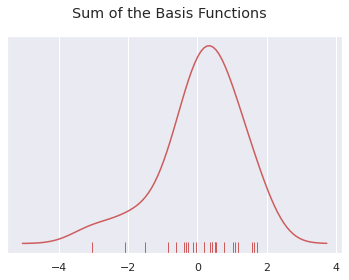

In [13]:
# To get the kde plot we can sum these basis functions.

# Plot the sum of the basis function
sum_of_kde = np.sum(kernel_list,axis=0)

# Plot figure
fig = plt.plot(x_axis,sum_of_kde,color='indianred')

# Add the initial rugplot
sns.rugplot(dataset,c = 'indianred')

# Get rid of y-tick marks
plt.yticks([])

# Set title
plt.suptitle("Sum of the Basis Functions")

So with our tips dataset:

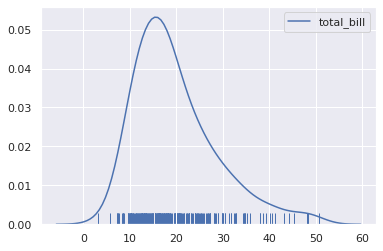

In [14]:
sns.kdeplot(tips['total_bill'])
sns.rugplot(tips['total_bill'])

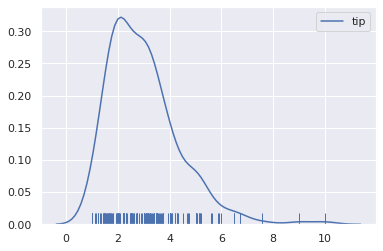

In [15]:
sns.kdeplot(tips['tip'])
sns.rugplot(tips['tip'])

In [16]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()